In [107]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
sns.set()

In [203]:
df = pd.read_csv("data/fc_features_first.csv", names=["from", "to", "CN", "AA", "RA", "target"])

In [204]:
df.head()

,from,to,CN,AA,RA,target
0,0.0,82.0,28.0,9.159,1.404,0.0
1,0.0,313.0,29.0,9.034,1.277,0.0
2,0.0,342.0,30.0,8.939,1.148,0.0
3,0.0,236.0,30.0,9.186,1.225,0.0
4,0.0,325.0,31.0,8.900,1.042,0.0


In [205]:
df.groupby("target")["CN", "AA", "RA"].median()

,CN,AA,RA
target,,,
0.0,10.0,2.850,0.279
1.0,27.0,6.802,0.549


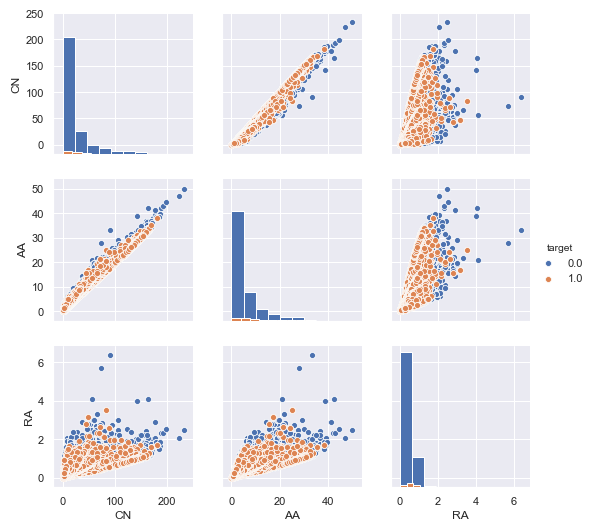

In [222]:
df_plot = df.loc[:, "CN":"target"]
sns.pairplot(df_plot, vars=["CN", "AA", "RA"], hue="target", diag_kind = 'hist')

In [223]:
model = LogisticRegression(solver="lbfgs", random_state=42, class_weight="balanced")
scaler = StandardScaler()

In [224]:
y = df.target
df_features = df[["CN", "AA", "RA"]]

In [225]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2)

In [226]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [227]:
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [228]:
y_pred = model.predict_proba(X_test_scaled)[:, 1]

In [229]:
cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

0.7211134804855933